In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# **IMPORTS**

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [101]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# **basic data queries**

In [102]:
def basic_queries(df):
    print(df.shape)
    print(df.describe()) 
    print(df.columns)
    print(df.isnull().sum())
    print(f"dupliacated col {df.duplicated().sum()}")
    print(df[df.duplicated(keep = 'first')].head())


In [103]:
basic_queries(df)


(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.369007e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.500885e-15 -5.620335e-16  1.149614e-16 -2.426963e-15   
std    1.380247e+00  1.332271

In [104]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [105]:
def plot_hist(df, col, bins=100):
    """
    Plots a custom histogram using matplotlib.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col (str): Column name for which the histogram is to be plotted.
        bins (int): Number of bins in the histogram.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[col], bins=bins, color='steelblue', edgecolor='black', alpha=0.8)
    
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

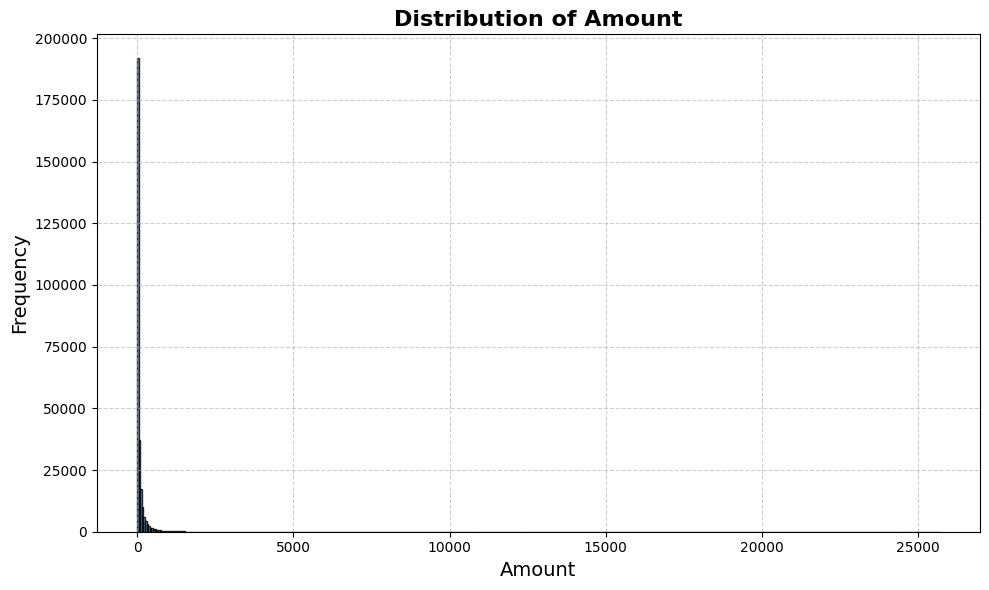

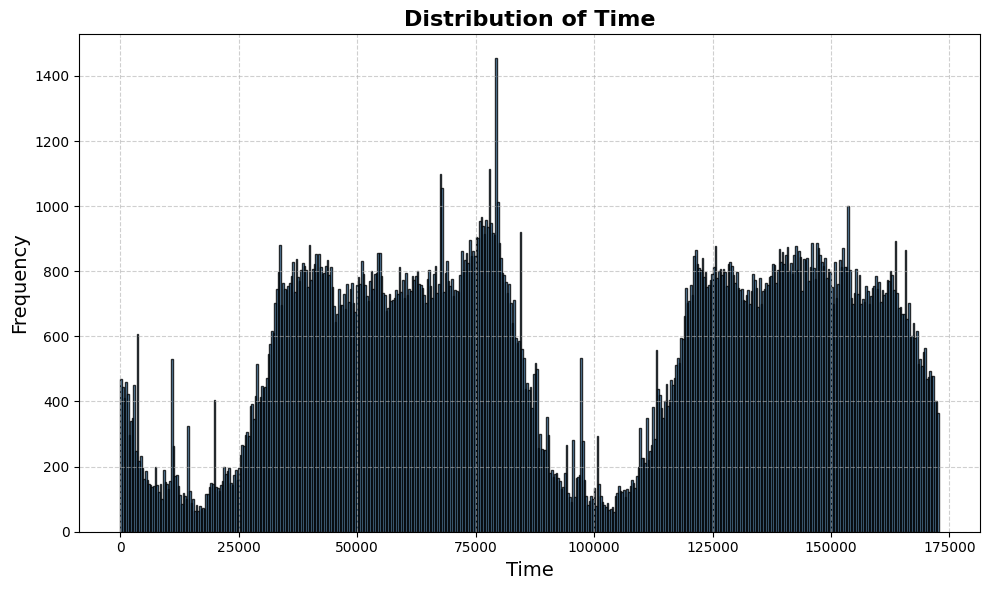

In [106]:
plot_hist(df, 'Amount', bins = 500)
plot_hist(df, 'Time', bins = 500)

In [107]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df_scaled = df.drop(['Time','Amount'], axis=1)

# **splitting data into train and test but with class balance**

In [108]:
X = df_scaled.drop(['Class'], axis = 1)
y = df_scaled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y, random_state= 42)


In [109]:
print(y_train.value_counts(normalize = True) *100)
print(y_test.value_counts(normalize = True) * 100)

Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64


# **UNDERSAMPLING**

In [110]:
def create_balanced(df, col):
    df = df.sample(frac = 1)
    fraud_df = df.loc[df['Class'] == 1]
    size = fraud_df.shape[0]
    non_fraud_df = df.loc[df['Class'] == 0][:size]

    balanced_df = pd.concat([fraud_df, non_fraud_df])

    balanced_df = balanced_df.sample(frac = 1, random_state = 42) 

    return balanced_df

    

In [111]:
train_data = pd.concat([X_train, y_train], axis = 1)
train_data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount',
       'scaled_time', 'Class'],
      dtype='object')

In [112]:
balanced_df = create_balanced(train_data, 'Class')
print(balanced_df['Class'].value_counts())

Class
0    394
1    394
Name: count, dtype: int64


**NOW ORDINARY MODEL CREATION**

In [113]:
def plot_numeric_heatmap(df, target_col):
    corr = df.select_dtypes(include='number').corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap (Numerical Features)')
    plt.tight_layout()
    plt.show()
    target_corr = corr[target_col].drop(target_col)  # Exclude self-correlation
    selected_features = target_corr[abs(target_corr) >= 0.6].sort_values(ascending=False)
    print(selected_features.index.tolist())


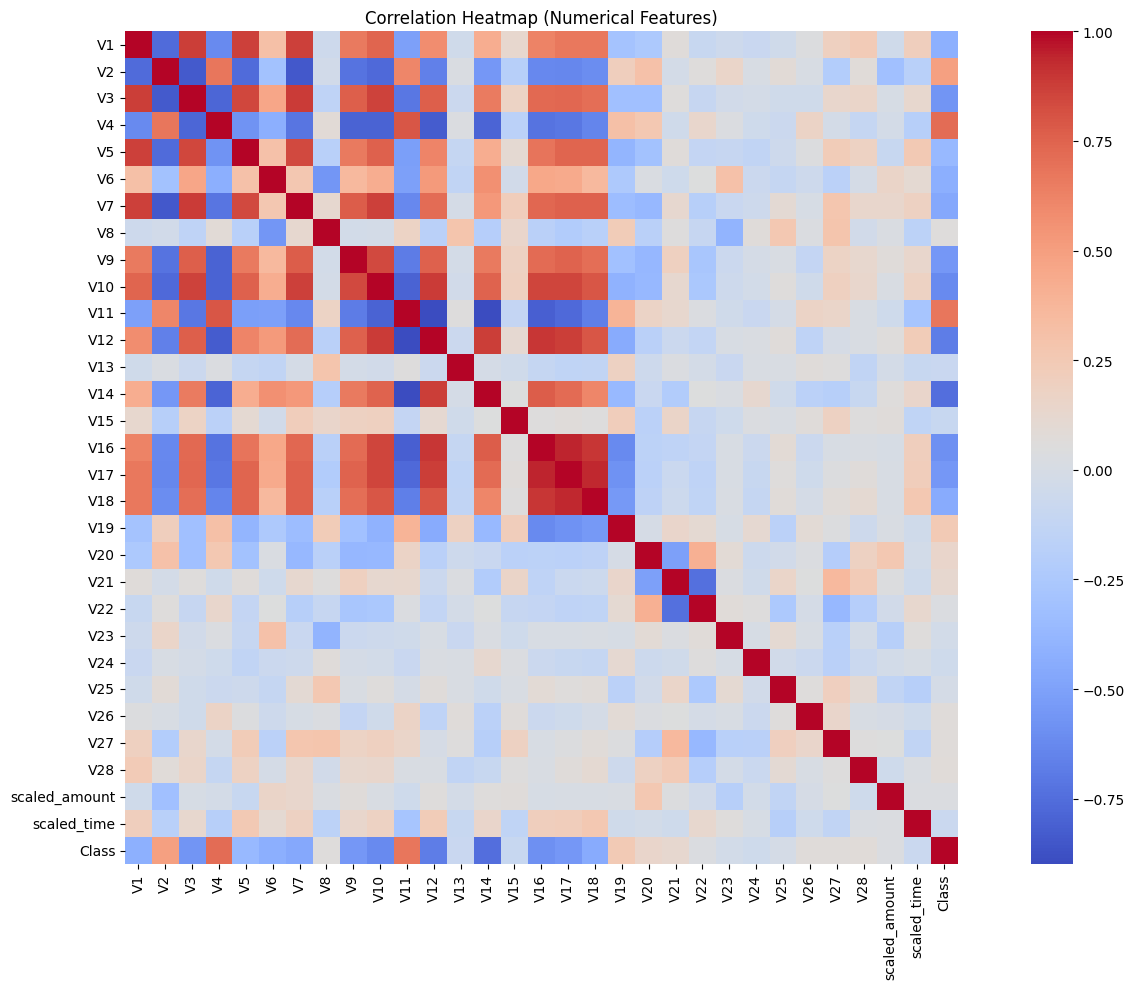

['V4', 'V11', 'V10', 'V12', 'V14']


In [114]:
plot_numeric_heatmap(balanced_df, 'Class')

# **ANOMALY DETECTION**

In [115]:
feature_col = ['V4', 'V11', 'V10', 'V12', 'V14']

In [116]:
def check_outliers(df, feature_cols):
    """
    Calculates the percentage of outliers for each feature using the IQR method.

    Parameters:
        df (pd.DataFrame): DataFrame with numerical features
        feature_cols (list): List of feature column names to check

    Returns:
        pd.DataFrame: Feature name and % of outliers
    """
    outlier_info = []

    for col in feature_cols:
        series = df[col].dropna()  # handle NaNs safely

        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((series < lower_bound) | (series > upper_bound)).sum()
        total = len(series)
        perc_outliers = 100 * outliers / total if total > 0 else 0

        outlier_info.append({
            'feature': col,
            'outlier_percent': round(perc_outliers, 2)
        })

    return pd.DataFrame(outlier_info).sort_values(by='outlier_percent', ascending=False).reset_index(drop=True)    

In [117]:
outliers = check_outliers(balanced_df, feature_col)
outliers

,feature,outlier_percent
0,V10,8.50
1,V12,4.70
2,V11,2.54
3,V4,1.90
4,V14,0.89


In [118]:
def kill_outlier(df, feature_cols):
    """
    Removes outliers from multiple columns based on the IQR method.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame
        feature_cols (list): List of feature columns to apply outlier removal

    Returns:
        clean_df (pd.DataFrame): DataFrame with outliers removed
        loss_percent (float): Percentage of rows removed overall
    """
    df_clean = df.copy()
    initial_rows = len(df_clean)

    for col in feature_cols:
        series = df_clean[col]
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    final_rows = len(df_clean)
    loss_percent = round(100 * (initial_rows - final_rows) / initial_rows, 2)

    return df_clean, loss_percent

In [119]:
df_clean, loss_percent = kill_outlier(balanced_df, feature_col)
loss_percent

10.03

In [120]:
def train_multiple_models(X_train, y_train, feature_space, models_dict):
    """
    Trains multiple models and returns a dict of fitted models.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.ndarray
        Training features.
    y_train : pd.Series or np.ndarray
        Training target.
    feature_space = list of cols
    models_dict : dict
        Dictionary of model_name: model_instance.

    Returns:
    --------
    dict
        Dictionary of model_name: trained_model.
    """
    trained_models = {}
    for name, model in models_dict.items():
        print(f"Training: {name}")
        X_train_ready = X_train[feature_space]
        model.fit(X_train_ready, y_train)
        trained_models[name] = model
    return trained_models

In [121]:

def evaluate_models(X_test, y_test, trained_models: dict, metrics: dict):
    """
    Evaluates multiple trained classification models on X_test and y_test.

    Parameters:
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): True test labels.
        trained_models (dict): Model name -> trained model object.
        metrics (dict): Metric name -> metric function.

    Returns:
        pd.DataFrame: Rows = model names, Columns = metric scores.
    """
    results = {}

    for model_name, model in trained_models.items():
        print(f"Evaluating: {model_name}")
        y_pred = model.predict(X_test)

        # Try to get predicted probabilities for metrics like ROC AUC
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None

        scores = {}
        for metric_name, metric_func in metrics.items():
            if metric_name == "roc_auc" and y_proba is not None:
                score = metric_func(y_test, y_proba)
            else:
                score = metric_func(y_test, y_pred)
            scores[metric_name] = round(score, 4)

        results[model_name] = scores

    return pd.DataFrame(results).T


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

model_dict = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'SVC': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

metric_dict = {
    # 'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    'recall': recall_score,
    'f1': f1_score,
    # 'roc_auc': roc_auc_score
    'PR_score': average_precision_score
}

In [124]:
feature_space = X_train.columns
trained_models = train_multiple_models(df_clean.drop(['Class'], axis = 1), df_clean['Class'], feature_space, model_dict)

Training: LogisticRegression
Training: RandomForest
Training: GradientBoosting
Training: XGBoost
Training: LightGBM
[LightGBM] [Info] Number of positive: 315, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7094
[LightGBM] [Info] Number of data points in the train set: 709, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [125]:
# evaluating over x_test
result = evaluate_models(X_test, y_test, trained_models, metric_dict)
result

Evaluating: LogisticRegression
Evaluating: RandomForest
Evaluating: GradientBoosting
Evaluating: XGBoost
Evaluating: LightGBM
Evaluating: SVC
Evaluating: KNN


,precision,recall,f1,PR_score
LogisticRegression,0.0334,0.9286,0.0644,0.0311
RandomForest,0.0618,0.9082,0.1157,0.0562
GradientBoosting,0.0280,0.9184,0.0544,0.0259
XGBoost,0.0233,0.9286,0.0455,0.0218
LightGBM,0.0372,0.9286,0.0716,0.0347
SVC,0.0639,0.9184,0.1194,0.0588
KNN,0.0649,0.9082,0.1212,0.0591


**models are catching frauds fine but also giving too much false positive (pissing the loyal customers)**